<a href="https://colab.research.google.com/github/Eason0227/Aidea-AOI/blob/main/AOI_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import gridspec
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import densenet
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# !unzip "aoi/train_images.zip" -d "aoi/"
# !unzip "aoi/test_images.zip" -d "aoi/"

train_df = pd.read_csv('aoi/train.csv')

## Check image imformation

image shape: (512, 512, 3)
data type: uint8
min: 109, max: 255


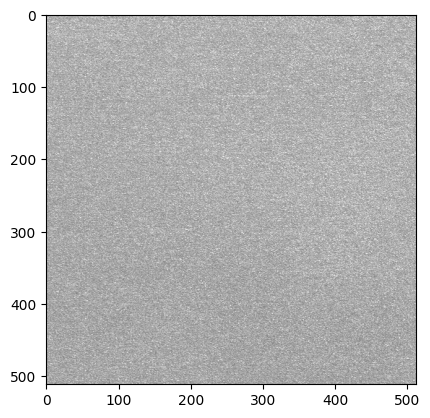

In [28]:
TRAIN_IMAGEPATH = 'aoi/train_images/'
img = cv2.imread(os.path.join(TRAIN_IMAGEPATH, train_df.loc[0, 'ID']))

print(f'image shape: {img.shape}')
print(f'data type: {img.dtype}')
print(f'min: {img.min()}, max: {img.max()}')

plt.imshow(img)
plt.show()

## Label : Defect type
---
0: normal  
1: void  
2: horizontal defect  
3: vertical defect  
4: edge defect  
5: particle

In [29]:
normal_list = train_df[train_df['Label'] == 0]['ID'].values
void_list = train_df[train_df['Label'] == 1]['ID'].values
horizontal_defect_list = train_df[train_df['Label'] == 2]['ID'].values
vertical_defect_list = train_df[train_df['Label'] == 3]['ID'].values
edge_defect_list = train_df[train_df['Label'] == 4]['ID'].values
particle_list = train_df[train_df['Label'] == 5]['ID'].values

label = [normal_list, void_list, horizontal_defect_list, vertical_defect_list, edge_defect_list, particle_list]
defect = ['normal', 'void', 'horizontal defect', 'vertical defect', 'edge defect', 'particle']

# label
# defect

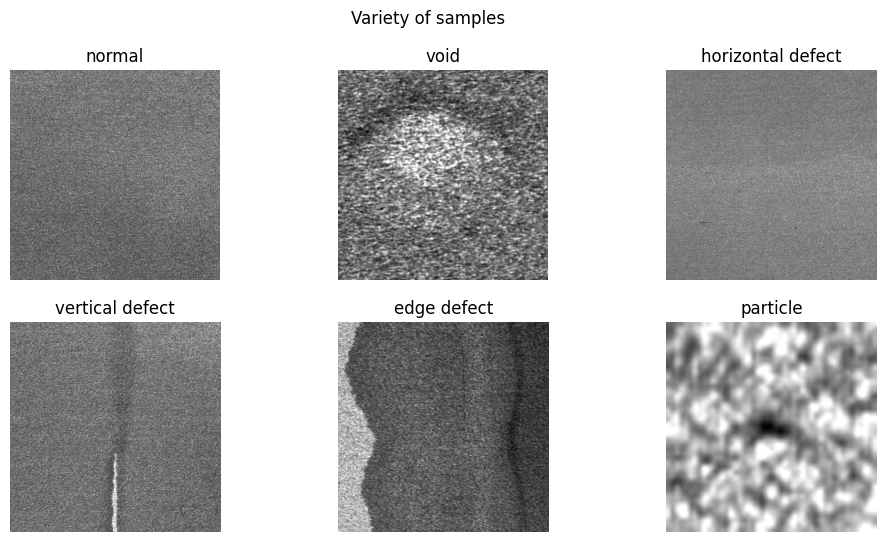

In [30]:
plt.figure(figsize=(12, 6))

for i in range(6):
  plt.subplot(2, 3, i+1)
  img = cv2.imread(os.path.join(TRAIN_IMAGEPATH, label[i][0]), 0)
  plt.imshow(img,cmap='gray')
  plt.axis('off')
  plt.title(defect[i])

plt.suptitle(f'Variety of samples', fontsize=12)
plt.show()

## Check the distribution of label

<Axes: xlabel='Label', ylabel='count'>

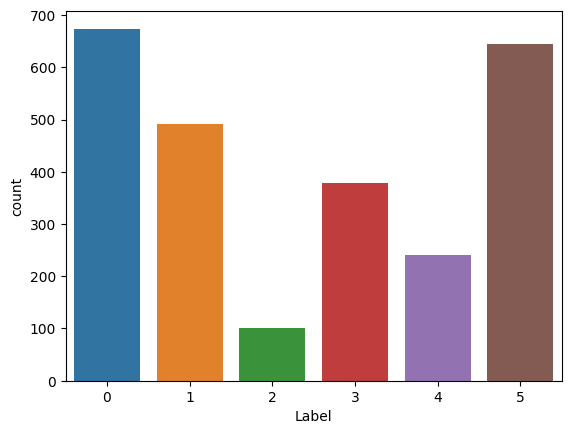

In [31]:
train_df['Label'].value_counts()
sns.countplot(x='Label', data=train_df)

## Training and validation data

In [32]:
train, valid = train_test_split(train_df, test_size=0.2, random_state=666)

train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)

train['Label'] = train['Label'].astype('str')
valid['Label'] = valid['Label'].astype('str')

## Dealing with data imbalance
Add a larger penalty value weight to the category with a small number of samples

In [33]:
unique, counts = np.unique(train['Label'].values, return_counts=True)

print('unique: ', unique)
print('counts: ', counts)

class_weights = compute_class_weight(class_weight='balanced', classes=unique, y=train['Label'])

print(class_weights)

unique:  ['0' '1' '2' '3' '4' '5']
counts:  [542 396  80 306 191 507]
[0.62177122 0.8510101  4.2125     1.10130719 1.76439791 0.66469428]


## Data Augmentation


In [34]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=False,
    vertical_flip=False,
    width_shift_range=0.05,
    height_shift_range=0.05,
    preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

## Input training and validation pictures
Using flow_from_dataframe does not need to mark the pictures, just place them all in one folder, but it is necessary to make a DataFrame, which must contain the name and label of the picture

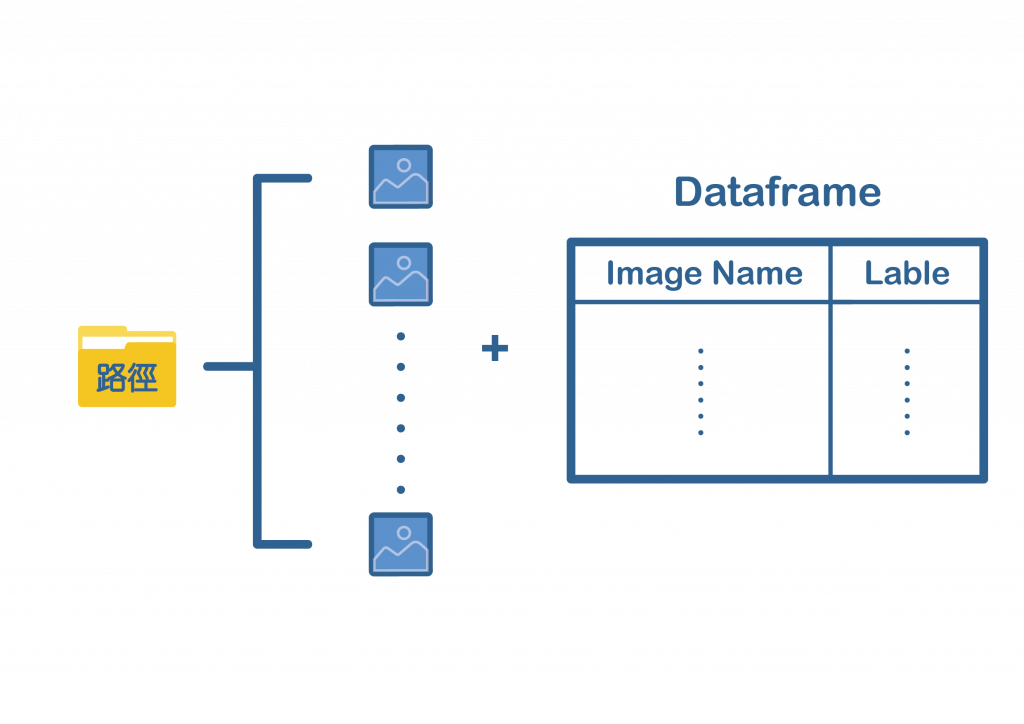

In [37]:
# img_shape should be set according to the input limit of the model
img_shape = (224, 224)
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=TRAIN_IMAGEPATH,
    x_col='ID',
    y_col='Label',
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid,
    directory= TRAIN_IMAGEPATH,
    x_col='ID',
    y_col='Label',
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

Found 2022 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


## Set the number of pictures for each epoch training

In [38]:
steps_per_epoch_train = len(train_generator)
steps_per_epoch_val= len(valid_generator)
steps_per_epoch_train

64

# Bulid model

In [39]:
# Load the pre-trained model densenet, apply the weight of imagenet
model = densenet.DenseNet169(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))

# Define the output layer, update the number of categories of the output
x = model.output
x = GlobalAveragePooling2D()(x)
output = Dense(6, activation='softmax')(x)
model = Model(inputs=model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

## Set the model training mechanism

In [40]:
#model.layers[0].trainable=False

# Used to store the model with the highest accuracy during the training process
model_dir = '/content/drive/MyDrive/Colab Notebooks/AOI/checkpoints'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
modelfile = model_dir + '/{}-best-model.h5'.format('densenet169')
checkpoint = ModelCheckpoint(
    modelfile,
    verbose=1,
    monitor='val_accuracy',
    save_best_only=True)

# Dynamic learning rate
reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    mode='min',
    verbose=1,
    min_learning_rate=1e-5)

# Earlystop：If the model does not improve for a 10 consecutive epochs, then terminate the model training early
estop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

callbacks_list = [checkpoint, estop, reduce_learning_rate]

# Increase the penalty weight for data imbalance
class_weights = {i:value for i, value in enumerate(class_weights)}

In [41]:
tf.config.list_physical_devices('GPU')

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [42]:
history=model.fit_generator(
  train_generator,steps_per_epoch=steps_per_epoch_train,
  epochs=50,
  validation_data=valid_generator,
  validation_steps=steps_per_epoch_val,
  class_weight=class_weights,
  callbacks=callbacks_list,
  verbose=2)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.62451, saving model to /content/drive/MyDrive/Colab Notebooks/AOI/checkpoints/densenet169-best-model.h5
64/64 - 156s - loss: 0.3961 - accuracy: 0.8531 - val_loss: 0.7388 - val_accuracy: 0.6245 - lr: 1.0000e-04 - 156s/epoch - 2s/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.62451 to 0.85968, saving model to /content/drive/MyDrive/Colab Notebooks/AOI/checkpoints/densenet169-best-model.h5
64/64 - 51s - loss: 0.0745 - accuracy: 0.9787 - val_loss: 0.3687 - val_accuracy: 0.8597 - lr: 1.0000e-04 - 51s/epoch - 791ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.85968 to 0.89723, saving model to /content/drive/MyDrive/Colab Notebooks/AOI/checkpoints/densenet169-best-model.h5
64/64 - 51s - loss: 0.0517 - accuracy: 0.9847 - val_loss: 0.2514 - val_accuracy: 0.8972 - lr: 1.0000e-04 - 51s/epoch - 793ms/step
Epoch 4/50

Epoch 4: val_accuracy improved from 0.89723 to 0.97233, saving model to /content/drive/MyDrive/Colab Notebo

## Visualize training result

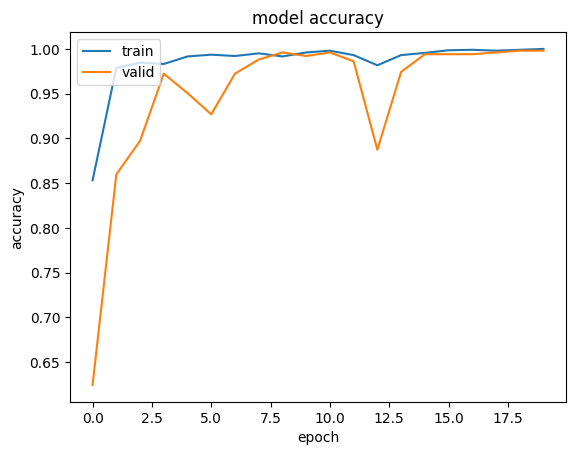

In [43]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

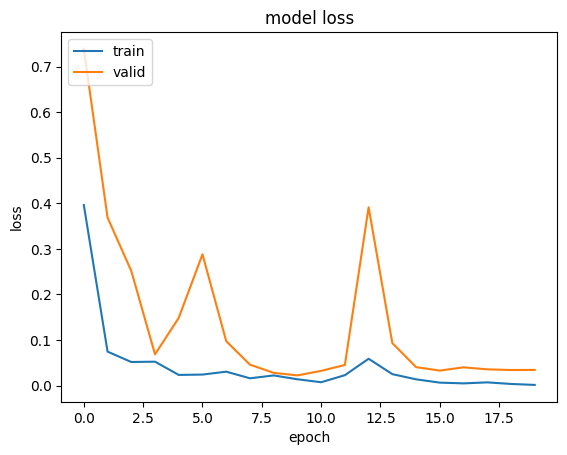

In [44]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## Testing data prediction

In [74]:
test_df = pd.read_csv('aoi/test.csv', index_col=False)
# test_df['Label'] = '7'
test_df['Label'] = test_df['Label'].astype('str')
test_df.head()

,ID,Label
0,train_00000.png,0
1,train_00001.png,1
2,train_00002.png,1
3,train_00003.png,5
4,train_00004.png,5


In [75]:
TEST_IMAGEPATH = 'aoi/train_images/'

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_IMAGEPATH,
    x_col='ID',
    y_col='Label',
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

test_steps = len(test_generator)

Found 400 validated image filenames belonging to 6 classes.


In [94]:
# Load best model
model_saved = load_model(modelfile)

# The prediction will be a probability, so it needs to be converted
y_test_predprob = model_saved.predict(test_generator, steps=test_steps)
y_test_pred = np.array(y_test_predprob.argmax(-1))
y_test = test_df['Label'].values.astype('int8')

print(y_test_pred)

13/13 [==============================] - 6s 227ms/step
[0 1 1 5 5 5 3 0 3 5 3 5 3 3 1 1 1 1 5 1 1 1 0 5 3 1 5 5 4 5 5 0 0 4 3 1 1
 0 0 1 1 5 1 5 5 5 3 1 1 1 4 0 3 3 5 0 1 0 5 5 5 5 3 5 0 0 1 0 3 5 5 0 1 5
 0 5 3 4 5 1 0 5 0 1 0 1 0 5 3 0 5 5 5 0 0 0 1 0 5 3 3 0 0 0 4 0 0 5 0 0 0
 4 1 5 3 0 0 0 2 0 3 5 1 5 1 2 1 3 2 5 1 0 4 4 1 4 0 2 3 0 1 5 3 4 1 0 5 0
 1 4 1 0 3 0 1 0 3 5 3 5 4 2 3 0 1 1 0 0 1 4 1 5 1 0 3 2 1 3 1 0 0 4 0 1 5
 5 3 0 0 5 4 1 5 1 0 4 3 3 5 1 5 4 0 1 5 1 0 0 3 1 5 5 5 5 3 5 1 3 4 0 2 1
 3 3 0 1 1 0 0 0 5 4 1 5 4 1 3 5 4 0 1 1 0 1 2 4 5 0 1 5 3 5 0 1 3 3 1 4 1
 5 5 3 2 0 5 4 4 3 5 1 4 5 5 5 5 1 5 1 1 5 4 0 3 0 1 3 1 3 3 4 5 3 5 5 0 5
 3 1 1 5 1 1 2 1 5 4 3 4 1 0 1 5 0 2 0 5 0 5 0 4 5 4 0 0 0 2 1 5 5 4 2 1 0
 4 1 1 5 4 3 3 3 3 5 0 1 0 5 0 3 0 1 3 5 0 3 0 1 4 0 1 5 5 3 3 0 4 0 0 5 1
 3 5 0 0 0 0 0 1 3 0 0 0 5 5 3 0 4 0 3 0 2 5 1 1 3 1 5 5 5 1]


accuracy_score: 1.000


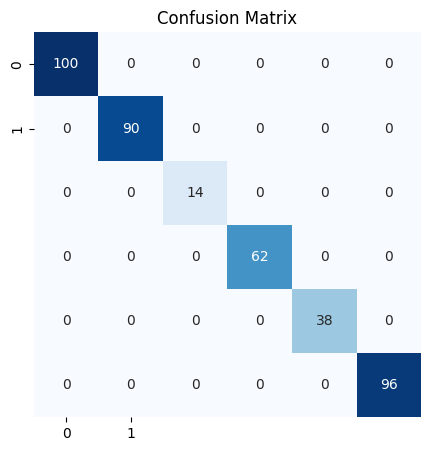

In [93]:
print(f'accuracy_score: {accuracy_score(y_test, y_test_pred):.3f}')

confusion = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(
    confusion_matrix(y_test, y_test_pred),
    cmap='Blues',
    annot=True,
    fmt='d',
    cbar=False,
    xticklabels=[0, 1],
    yticklabels=[0, 1])

plt.title('Confusion Matrix')
plt.show()

In [49]:
# test_df['Label'] = y_test_pred
# test_df.to_csv('/content/drive/My Drive/Colab Notebooks/AOI/submit.csv')